# FACE MASK DETECTOR

## About data set :

According to this motivation we demand mask detection as a unique and public health service system
during the global pandemic COVID-19 epidemic. The model is trained by face mask image and nonface mask image.

## Problem Statement :

The main objective of the face detection model is to detect the face of individuals and conclude
whether they are wearing masks or not at that particular moment when they are captured in the image.

## Import the necessary libraries.

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

# DATA PREPROCESSING

* Initialize the initial learning rate,
* Initialize number of epochs to train for,and batch size

In [32]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

## Read data set.

In [33]:
DIRECTORY = r"C:\Users\DELL\Desktop\internship\dataset\dataset"
CATEGORIES = ["with_mask", "without_mask"]

 * Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [34]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


[INFO] loading images...


C:\Users\DELL\anaconda3\envs\yolo\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


* Perform one-hot encoding on the labels

In [35]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

 * Construct the training image generator for data augmentation

In [36]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# MODEL BUILDING

* load the MobileNetV2 network, ensuring the head FC layer sets are left off

In [37]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

* Construct the head of the model that will be placed on top of the the base model

In [38]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

* Place the head FC model on top of the base model (this will become the actual model we will train)

In [39]:
model = Model(inputs=baseModel.input, outputs=headModel)

* Loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [40]:
for layer in baseModel.layers:
    layer.trainable = False

* Compile our model

In [41]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


C:\Users\DELL\anaconda3\envs\yolo\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* Train the head of the network

In [42]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 128s 1s/step - loss: 0.3940 - accuracy: 0.8593 - val_loss: 0.1551 - val_accuracy: 0.9685
Epoch 2/20
95/95 [==============================] - 119s 1s/step - loss: 0.1456 - accuracy: 0.9648 - val_loss: 0.0862 - val_accuracy: 0.9803
Epoch 3/20
95/95 [==============================] - 114s 1s/step - loss: 0.0923 - accuracy: 0.9778 - val_loss: 0.0636 - val_accuracy: 0.9829
Epoch 4/20
95/95 [==============================] - 113s 1s/step - loss: 0.0748 - accuracy: 0.9778 - val_loss: 0.0550 - val_accuracy: 0.9843
Epoch 5/20
95/95 [==============================] - 114s 1s/step - loss: 0.0635 - accuracy: 0.9818 - val_loss: 0.0497 - val_accuracy: 0.9869
Epoch 6/20
95/95 [==============================] - 114s 1s/step - loss: 0.0540 - accuracy: 0.9821 - val_loss: 0.0437 - val_accuracy: 0.9895
Epoch 7/20
95/95 [==============================] - 112s 1s/step - loss: 0.0555 - accuracy: 0.9831 - val_loss: 0.0419 - val_accura

* Make predictions on the testing set

In [43]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...
24/24 [==============================] - 23s 837ms/step


* For each image in the testing set we need to find the index of the label with corresponding largest predicted probability

In [44]:
predIdxs = np.argmax(predIdxs, axis=1)

* Show a nicely formatted classification report

In [45]:
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       378
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       762
   macro avg       0.99      0.99      0.99       762
weighted avg       0.99      0.99      0.99       762



* Serialize the model to disk

In [46]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] saving mask detector model...


# MODEL TRAINING

* Plot the training loss and accuracy

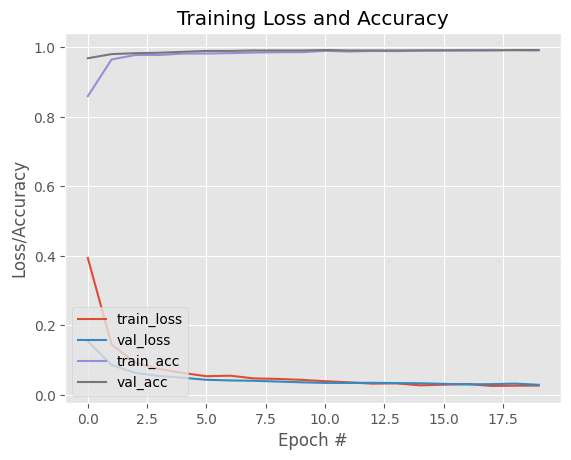

In [47]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# IMPLEMENTING DETECTOR FOR VEDIO STREAMING

* Import the necessary packages

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

In [2]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)
    # initialize our list of faces, their corresponding locations,and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    
#loop over the detections
    for i in range(0, detections.shape[2]):
# extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]
# filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > 0.5:
# compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

# ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        
# extract the face ROI, convert it from BGR to RGB channel ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

# add the face and bounding boxes to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

# only make a predictions if at least one face was detected
    if len(faces) > 0:
# for faster inference we'll make batch predictions 
#on all faces at the same time rather than one-by-one predictions in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

# return a 2-tuple of the face locations and their corresponding locations
    return (locs, preds)
# load our serialized face detector model from disk

prototxtPath = r"C:\Users\DELL\Desktop\internship\face_detector\face_detector\deploy.prototxt"
weightsPath = r"C:\Users\DELL\Desktop\internship\face_detector\face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk

maskNet = load_model("mask_detector.model")

# initialize the video stream

print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()


# loop over the frames from the video stream
while True:
# grab the frame from the threaded video stream and resize it to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
# detect faces in the frame and determine if they are wearing a face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

# loop over the detected face locations and their corresponding locations
    for (box, pred) in zip(locs, preds):
# unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

# determine the class label and color we'll use to draw the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

# include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

# display the label and bounding box rectangle on the output frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

# show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

# if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()




[INFO] starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 2